In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from cleanin import clean_titles, first_genre_filmweb, down_sample_both_dfs

In [3]:
## test functions before running
!python test_function.py -v

test_multiple (__main__.GenreTakerTest) ... ok
test_single (__main__.GenreTakerTest) ... ok
test_single_larger (__main__.GenreTakerTest) ... ok
test_single_multiple (__main__.GenreTakerTest) ... ok
test_equal (__main__.SamplingTest) ... ok
test_not_equal (__main__.SamplingTest) ... ok
test_all (__main__.TitleCleaningTest) ... ok
test_proper (__main__.TitleCleaningTest) ... ok
test_upper (__main__.TitleCleaningTest) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.027s

OK


### EDA + cleaning

In [4]:
## Read filmweb data
df_filmweb = pd.read_csv("data/filmweb.csv")
df_filmweb.head()

,title,originalTitle,year,description,genre
0,Zielona mila,The Green Mile,1999,Emerytowany strażnik więzienny opowiada przyja...,Dramat
1,Skazani na Shawshank,The Shawshank Redemption,1994,Adaptacja opowiadania Stephena Kinga. Niesłusz...,Dramat
2,Forrest Gump,NaN,1994,"Historia życia Forresta, chłopca o niskim ilor...","Dramat, Komedia"
3,Leon zawodowiec,Léon,1994,Płatny morderca ratuje dwunastoletnią dziewczy...,"Dramat, Kryminał"
4,Requiem dla snu,Requiem for a Dream,2000,"Historia czwórki bohaterów, dla których używki...",Dramat


In [5]:
## Read train imdb data
df_imdb_1 = pd.read_csv('data/train_data.txt', sep=":::", header=None, engine='python')
df_imdb_1.columns = ['id', 'title', 'genre', 'description']
df_imdb_1 = df_imdb_1.drop(columns=["id"])

In [6]:
## Read test imdb data
df_imdb_2 = pd.read_csv('data/test_data_solution.txt', sep=":::", header=None, engine='python')
df_imdb_2.columns = ['id', 'title', 'genre', 'description']
df_imdb_2 = df_imdb_2.drop(columns=["id"])

In [7]:
## Combine the imdb datasets to create one big dataset
df_imdb_all = pd.concat([df_imdb_1, df_imdb_2], axis=0).reset_index(drop=True)

In [8]:
## Compare the sizes of two datasets
print(f"Number of samples in filmweb dataset {df_filmweb.shape[0]:,}")
print(f"Number of samples in imdb dataset {df_imdb_all.shape[0]:,}")

Number of samples in filmweb dataset 9,951
Number of samples in imdb dataset 108,414


In [9]:
## Check for Nan's

In [10]:
## We can get the "originalTitle" from the title column
## Because if the title is the same as originalTitle then the second column
## has a NaN as an entry
df_filmweb.isna().sum()

title               0
originalTitle    2374
year                0
description         0
genre               0
dtype: int64

In [11]:
df_imdb_all.isna().sum()

title          0
genre          0
description    0
dtype: int64

In [12]:
## If the "originalTitle" is None then the "title" is the "originalTitle"
df_filmweb["originalTitle"][df_filmweb["originalTitle"].isna()] = df_filmweb["title"][df_filmweb["originalTitle"].isna()]

## Let's also drop the "title" column because it's no longer needed and rename the "originalTitle" column to "title"
df_filmweb = df_filmweb.drop(columns="title").rename({"originalTitle": "title"}, axis=1)

/tmp/ipykernel_12105/3073694373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filmweb["originalTitle"][df_filmweb["originalTitle"].isna()] = df_filmweb["title"][df_filmweb["originalTitle"].isna()]


In [13]:
## Check again for missing values for filmweb dataset
df_filmweb.isna().sum()

title          0
year           0
description    0
genre          0
dtype: int64

In [14]:
## Check unique genres in each move database

In [15]:
df_imdb_all.genre.nunique()

27

In [16]:
## Let's inspect what's going on here
df_filmweb.genre.nunique()

1014

In [17]:
## As we can probably deduce a movie can belong to multiple genre
## For the sake of comparison with imdb dataset let's
## only take the first occuring genre as the "true" genre of the movie
## But before that let's first check for the existance of the same
## movies in both datasets, so we can compare them later
df_filmweb.genre.value_counts()

Dramat                                        1021
Komedia                                        490
Horror                                         489
Dramat, Komedia                                381
Thriller                                       361
                                              ... 
Dramat, Fantasy, Niemy                           1
Familijny, Fantasy, Romans                       1
Animacja, Dla dzieci, Komedia, Przygodowy        1
Dramat, Psychologiczny, Anime                    1
Kryminał, Biograficzny, Dramat historyczny       1
Name: genre, Length: 1014, dtype: int64

Let's inspect how the title of both datasets look like

In [18]:
df_filmweb.title

0                 The Green Mile
1       The Shawshank Redemption
2                   Forrest Gump
3                           Léon
4            Requiem for a Dream
                  ...           
9946      Paul Blart: Mall Cop 2
9947         The Next Best Thing
9948                        Upał
9949                    Evidence
9950         Highlander: Endgame
Name: title, Length: 9951, dtype: object

In [19]:
df_imdb_all.title

0              Oscar et la dame rose (2009) 
1                              Cupid (1997) 
2          Young, Wild and Wonderful (1980) 
3                     The Secret Sin (1915) 
4                    The Unrecovered (2007) 
                         ...                
108409       "Tales of Light & Dark" (2013) 
108410          Der letzte Mohikaner (1965) 
108411                  Oliver Twink (2007) 
108412                    Slipstream (1973) 
108413            Curitiba Zero Grau (2010) 
Name: title, Length: 108414, dtype: object

Unfortunately the imdb dataset contains also the year in which the movie was released(probably), therefore right now we won't be able to check if there are any movies that belong to both datasets, so let's clean the title column in both of the datasets <br>
The cleaning consists of deleting the "(year)" part from each title and also dropping the special characters and making each of them a lower case character.

In [20]:
## Cleanin'
titles_filmweb = df_filmweb["title"].pipe(clean_titles)
titles_imdb = df_imdb_all["title"].pipe(clean_titles)

In [21]:
# get date of films from title column
df_imdb_all["year"] = df_imdb_all.title.str.extract(r"(\([0-9]+\))", expand=False).str.replace(pat=r"(\(|\))", repl="", regex=True)
df_imdb_all.head(3)

,title,genre,description,year
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,2009
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,1997
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1980


In [22]:
titles_imdb

0             oscar et la dame rose
1                             cupid
2         young, wild and wonderful
3                    the secret sin
4                   the unrecovered
                    ...            
108409        tales of light & dark
108410         der letzte mohikaner
108411                 oliver twink
108412                   slipstream
108413           curitiba zero grau
Name: title, Length: 108414, dtype: object

In [23]:
## Let's check how many titles belong to both datasets
len(set(titles_filmweb) & set(titles_imdb))

2019

In [24]:
## Let's replace the the titles with the cleaned ones
df_filmweb["title"] = df_filmweb["title"].pipe(clean_titles)
df_imdb_all["title"] = df_imdb_all["title"].pipe(clean_titles)

In [25]:
df_filmweb.head()

,title,year,description,genre
0,the green mile,1999,Emerytowany strażnik więzienny opowiada przyja...,Dramat
1,the shawshank redemption,1994,Adaptacja opowiadania Stephena Kinga. Niesłusz...,Dramat
2,forrest gump,1994,"Historia życia Forresta, chłopca o niskim ilor...","Dramat, Komedia"
3,leon,1994,Płatny morderca ratuje dwunastoletnią dziewczy...,"Dramat, Kryminał"
4,requiem for a dream,2000,"Historia czwórki bohaterów, dla których używki...",Dramat


In [26]:
df_imdb_all.head()

,title,genre,description,year
0,oscar et la dame rose,drama,Listening in to a conversation between his do...,2009
1,cupid,thriller,A brother and sister with a past incestuous r...,1997
2,"young, wild and wonderful",adult,As the bus empties the students for their fie...,1980
3,the secret sin,drama,To help their unemployed father make ends mee...,1915
4,the unrecovered,drama,The film's title refers not only to the un-re...,2007


In [27]:
df_imdb_all = df_imdb_all.iloc[:, [0,3,2,1]]
## I've seen that the genre column in imdb dataset was padded with spaces
## and the belowe cell with filmweb data manipulation did not work because of that
## so I've stripped it from those spaces
df_imdb_all["genre"] = df_imdb_all["genre"].str.strip()
df_imdb_all

,title,year,description,genre
0,oscar et la dame rose,2009,Listening in to a conversation between his do...,drama
1,cupid,1997,A brother and sister with a past incestuous r...,thriller
2,"young, wild and wonderful",1980,As the bus empties the students for their fie...,adult
3,the secret sin,1915,To help their unemployed father make ends mee...,drama
4,the unrecovered,2007,The film's title refers not only to the un-re...,drama
...,...,...,...,...
108409,tales of light & dark,2013,"Covering multiple genres, Tales of Light & Da...",horror
108410,der letzte mohikaner,1965,As Alice and Cora Munro attempt to find their...,western
108411,oliver twink,2007,A movie 169 years in the making. Oliver Twist...,adult
108412,slipstream,1973,"Popular, but mysterious rock D.J Mike Mallard...",drama


In [28]:
len(df_filmweb)

9951

In [29]:
## Okey so now that we have cleaned titles let's clean the genres for filmweb dataset
df_filmweb = df_filmweb.pipe(first_genre_filmweb, set(df_imdb_all.genre))
df_filmweb

,title,year,description,genre
0,the green mile,1999,Emerytowany strażnik więzienny opowiada przyja...,drama
1,the shawshank redemption,1994,Adaptacja opowiadania Stephena Kinga. Niesłusz...,drama
4,requiem for a dream,2000,"Historia czwórki bohaterów, dla których używki...",drama
6,the silence of the lambs,1991,Seryjny morderca i inteligentna agentka łączą ...,thriller
7,gladiator,2000,"Generał Maximus - prawa ręka cesarza, szczęśli...",drama
...,...,...,...,...
9941,mes tresors,2016,"Carole jest introwertyczką, której całe życie...",comedy
9944,spinning man,2018,"Profesor, który ma opinię kobieciarza, staje s...",thriller
9946,paul blart: mall cop 2,2015,Paul Bart przyjeżdża do Las Vegas na spotkanie...,comedy
9947,the next best thing,2000,Abbie zachodzi w ciążę po nocy spędzonej ze sw...,comedy


In [30]:
len(df_filmweb)

3961

In [31]:
## Let's once again see how many movies are the same in both datasets
## We've lost some movies due to "genre missmatch"(might think about it later)
titles_filmweb = df_filmweb["title"].pipe(clean_titles)
titles_imdb = df_imdb_all["title"].pipe(clean_titles)
len(set(titles_filmweb) & set(titles_imdb))

1139

In [32]:
len(df_filmweb)

3961

In [33]:
## Let's also check how many movies that belong to both datasets have the same genre
## Not bad, 1178 movies belong to the same genres according to both datasets
len( set(zip(df_filmweb.title, df_filmweb.genre)) & set(zip(df_imdb_all.title, df_imdb_all.genre)) )

863

In [34]:
unique_genres_imdb = df_imdb_all.genre.str.strip().unique()

In [35]:
boolean_mask = df_filmweb.genre.isin(unique_genres_imdb)

In [36]:
len(df_filmweb)

3961

In [37]:
df_filmweb = df_filmweb[boolean_mask].reset_index(drop=True)

In [38]:
df_filmweb.groupby("genre").size().sort_values(ascending=False)

genre
drama          1482
comedy          990
thriller        520
horror          489
documentary     138
action          103
western          50
crime            47
adventure        47
sci-fi           30
romance          16
family           11
war              10
biography         8
fantasy           8
animation         4
musical           3
short             3
music             2
dtype: int64

In [39]:
len(df_filmweb)

3961

In [40]:
df_imdb_all.groupby("genre").size().sort_values(ascending=False)

genre
drama          27225
documentary    26192
comedy         14893
short          10145
horror          4408
thriller        3181
action          2629
western         2064
reality-tv      1767
family          1567
adventure       1550
music           1462
romance         1344
sci-fi          1293
adult           1180
crime           1010
animation        996
sport            863
talk-show        782
fantasy          645
mystery          637
musical          553
biography        529
history          486
game-show        387
news             362
war              264
dtype: int64

We would prorably have to think about what to do with movies that have less than {n} number of samples because it would be hard to get anything meaningful from them

In [41]:
## drop movies with duplicated descriptions
df_filmweb = df_filmweb.drop_duplicates(subset=["description"])
df_imdb_all = df_imdb_all.drop_duplicates(subset=["description"])

In [42]:
df_filmweb.to_csv("data/df_filmweb.csv", index=False)
df_imdb_all.to_csv("data/df_imdb.csv", index=False)

In [43]:
## Script to split the data into sets for further
# !python create_datasets.py data/df_filmweb.csv data/df_imdb.csv splits.csv

In [44]:
## n_min - minimum number of samples 
## n_max - maximum number of samples
df_filmweb_sampled, df_imdb_all_sampled = down_sample_both_dfs(df_filmweb, df_imdb_all, n_min=400, n_max=400)

In [45]:
(df_filmweb_sampled.groupby("genre").size() == df_imdb_all_sampled.groupby("genre").size()).all()

True

## Tfidf

In [46]:
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

In [47]:
with open('polish_stopwords.txt') as f:
    lines = f.readlines()

In [48]:
stopwords_polish = [line.strip('\n') for line in lines]
stopwords_polish.extend(['nbsp', 'zostaje'])

In [49]:
def process_documents(df_database, result_tfidf):
    genre_df = pd.DataFrame()
    for genre in df_database.genre.unique():
        bool_mask = df_database.genre == genre
        summed_scores = result_tfidf[bool_mask].sum(axis=0)
        temp_df = pd.DataFrame(index=[genre], data=[summed_scores])
        genre_df = pd.concat([genre_df, temp_df], axis=0)
    return genre_df

In [50]:
class GenresAverageTfidf:
    def __init__(self, df_database, stopwords):
        self.df_database = df_database
        self.stopwords = stopwords
        self.calculate_tfidf()

    def calculate_tfidf(self):

        vec = TfidfVectorizer(ngram_range=(1,1), stop_words=self.stopwords)
        text_set = self.df_database['description'].to_list()
        tf_idf = vec.fit_transform(text_set)
        result_tfidf = pd.DataFrame(tf_idf.toarray(), columns=vec.get_feature_names_out())

        self.genre_df = process_documents(self.df_database, result_tfidf=result_tfidf)
        

    def show_keywords(self, genre, n, normalize=False):
        if not hasattr(self, 'genre_df'):
            self.calculate_tfidf()
        
        test_tfidf_row = self.genre_df.loc[genre]
        keywords_df = pd.DataFrame({
            'keyword':test_tfidf_row.index,
            'tf-idf':test_tfidf_row.values
        })
        keywords_df = keywords_df[
            keywords_df['tf-idf'] > 0
        ].sort_values(by=['tf-idf'],ascending=False)
        keywords_df = keywords_df[:n]
        keywords_df['tf-idf'] = keywords_df['tf-idf'] / (sum(keywords_df['tf-idf']) if normalize else 1)
        return keywords_df
        



In [51]:
filmweb_average_tfidf = GenresAverageTfidf(df_filmweb_sampled, stopwords_polish)
imdb_average_tfidf = GenresAverageTfidf(df_imdb_all_sampled, 'english')

In [52]:
df_filmweb_sampled.genre.unique()

array(['drama', 'comedy', 'horror', 'thriller'], dtype=object)

In [55]:
filmweb_average_tfidf.show_keywords('horror', 10, True)

,keyword,tf-idf
1243,domu,0.174791
1955,grupa,0.173035
4277,odkrywa,0.116983
8078,wkrótce,0.082782
8634,zaczynają,0.080335
5811,przyjaciół,0.078846
3573,młoda,0.076596
3088,ludzi,0.074786
2578,kobieta,0.071198
8633,zaczyna,0.070646


In [56]:
imdb_average_tfidf.show_keywords('horror', 10, True)

,keyword,tf-idf
7028,house,0.142954
6406,group,0.109793
9995,night,0.104684
3723,dead,0.100657
6997,horror,0.098551
16432,young,0.098541
5383,family,0.094699
5142,evil,0.088670
10249,old,0.081851
15032,town,0.079601


## EDA

In [46]:
df_filmweb_sampled.sample(frac=1., random_state=42)

,title,year,description,genre
526,suspiria,1977,Susy Bannion przyjeżdża do najsłynniejszej wie...,horror
354,the meaning of life,1983,Grupa Monty Pythona postanawia pokazać czym je...,comedy
168,anything else,2003,"Jerry zaprzyjaźnia się ze starszym mężczyzną, ...",comedy
135,yyyreek!!! kosmiczna nominacja,2002,Irek zatrzymuje się w zakopiańskim pensjonacie...,comedy
937,linconnu du lac,2013,Podczas cruisingu po plaży dla gejów główny bo...,drama
...,...,...,...,...
1130,virginia,2010,Szeryf Tipton (Ed Harris) startuje w wyborach...,drama
1294,i still see you,2018,"Dziesięć lat po apokalipsie, w efekcie której...",thriller
860,the music never stopped,2011,"Gabriel cierpi na guza mózgu, który powoduje z...",drama
1459,diabolique,1996,Przyjaźniące się nauczycielki w szkole katolic...,thriller


In [47]:
df_imdb_all_sampled.sample(frac=1., random_state=42)

,title,year,description,genre
526,san chuen liu see,1999,"""A Wicked Ghost"" starts with four youngsters ...",horror
354,"oute gata, oute zimia",1955,Lalakis is married with Poppe. He goes on a t...,comedy
168,all together now,2003,The story revolves around the three main cast...,comedy
135,caught in the act,2008,"CAUGHT IN THE ACT is a hilarious, heart-warmi...",comedy
937,parampara,2003,The film follows the poor life of grand mothe...,drama
...,...,...,...,...
1130,amma,1986,On The Day Of Marriage Of Shanta (Rakhi Gulza...,drama
1294,dead dreams,2011,Carl finds himself in a deserted motel suffer...,thriller
860,ambush in leopard street,1962,A former thief comes out of retirement for on...,drama
1459,gumnam hai koi,2001,Ila lives a wealthy lifestyle in Mumbai along...,thriller


In [48]:
## Let's do some more EDA now

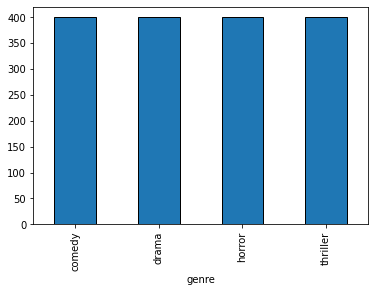

In [49]:
## The same as with imdb dataset (right now at least)
df_filmweb_sampled.groupby("genre").size().plot.bar(edgecolor="k")
plt.show()

Let's check for average number of words by genre in two datasets

In [90]:
df_filmweb_sampled["words_per_description"] = df_filmweb_sampled["description"].str.split().apply(len)
df_imdb_all_sampled["words_per_description"] = df_imdb_all_sampled["description"].str.split().apply(len)

In [91]:
percentile97 = df_imdb_all_sampled["words_per_description"].quantile(0.97)

In [92]:
percentile97

283.03

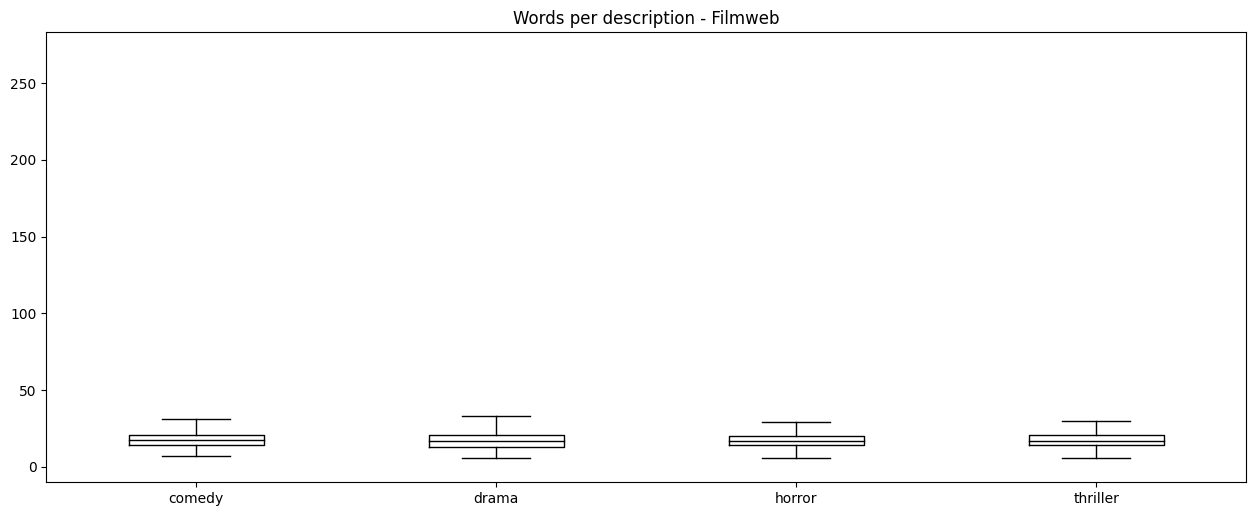

In [93]:
df_filmweb_sampled.boxplot("words_per_description", by="genre", grid=False,
showfliers=False, color="black", figsize=(15, 6))
plt.ylim((-10, percentile97))
plt.title("Words per description - Filmweb")
plt.suptitle("")
plt.xlabel("")
plt.show()

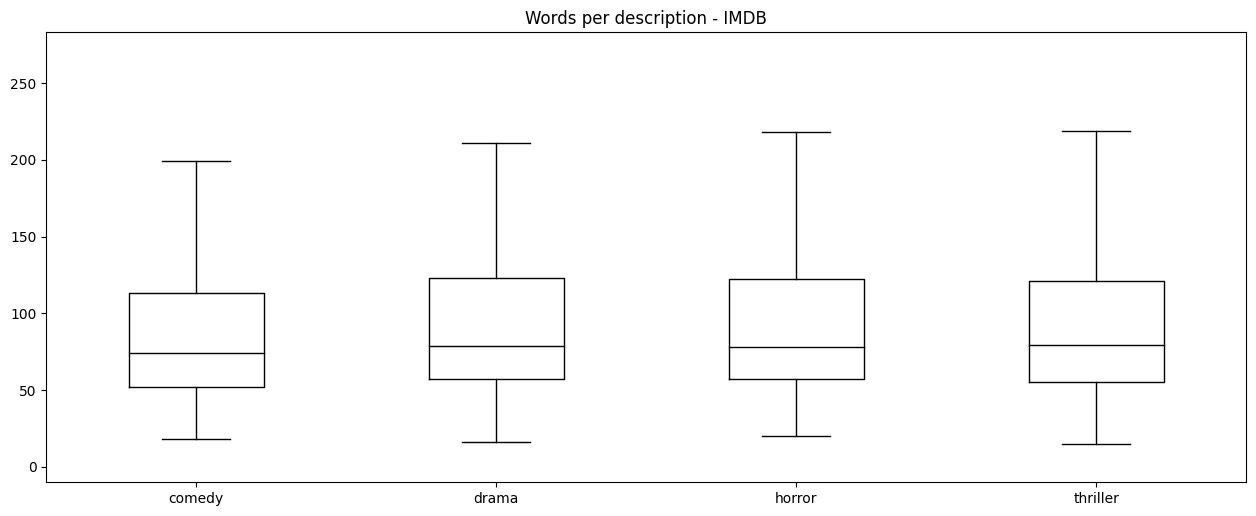

In [94]:
df_imdb_all_sampled.boxplot("words_per_description", by="genre", grid=False,
showfliers=False, color="black", figsize=(15, 6))
plt.title("Words per description - IMDB")
plt.ylim(-10, percentile97)
plt.suptitle("")
plt.xlabel("")
plt.show()

#### Some tests with oversampling
This might be needed because classes are heavely imbalanced, but to get something better than random over sampling we would first have to get the feature vector
which will be produced by BERT(at least that's what we plan to use at the moment)

In [49]:
from imblearn.over_sampling import RandomOverSampler

In [50]:
X_filmweb, y_filmweb = df_filmweb_sampled[["title", "description"]], df_filmweb_sampled["genre"]

In [51]:
np.array(X_filmweb).reshape(-1, 2).shape

(2000, 2)

In [52]:
ros = RandomOverSampler(random_state=0)

In [53]:
X_resampled, y_resampled = ros.fit_resample(np.array(X_filmweb).reshape(-1, 2), np.array(y_filmweb).reshape(-1, 1))

In [54]:
pd.Series(y_resampled).value_counts(normalize=True)

drama        0.2
thriller     0.2
comedy       0.2
horror       0.2
biography    0.2
dtype: float64

In [55]:
pd.DataFrame(X_resampled, columns=["title", "description"])

,title,description
0,bak-jwi,Podczas badań nad śmiertelnym wirusem ksiądz z...
1,la solitudine dei numeri primi,"Adaptacja książki Paolo Giordano pt. ""Samotno..."
2,wu ji,"Kilkuletnia Qingcheng składa przysięgę, na moc..."
3,il conformista,Faszystowskie Włochy. Marcello (Jean-Louis Tr...
4,ondskan,Erik trafia do elitarnego internatu. W nowym m...
...,...,...
1995,house of gucci,"Historia Patrizii Reggiani, byłej żony Maurizi..."
1996,fur: an imaginary portrait of diane arbus,Gdy Diane Arbus poznaje ekscentrycznego sąsiad...
1997,anna and the king,Na dwór króla Syjamu przybywa angielska guwern...
1998,monster,"Historia amerykańskiej prostytutki, która po d..."
